# Yelp Dataset: Data Analysis



In [32]:
# data handling
import pandas as pd
import numpy as np

# data modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

#visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in data
df  = pd.read_csv("data/services_reviews.csv", parse_dates=["date"])
print(df.shape)
df.head()

(226830, 39)


,user_id,business_id,stars,text,date,business_name,business_stars,categories,aircraft_repairs,appliances_and_repair,...,motorsport_vehicle_repairs,rv_repair,sauna_installation_and_repair,shoe_repair,trailer_repair,transmission_repair,watch_repair,water_heater_installation_and_repair,wheel_and_rim_repair,windshield_installation_and_repair
0,vXZeHaLvdfCPATz5BDavow,FQ1wBQb3aNeRMThSQEV0Qg,5,PlumbSmart provided superior service from begi...,2013-12-07 02:32:45,PlumbSmart Plumbing Heating and Air,4.0,"Damage Restoration, Heating & Air Conditioning...",0,0,...,0,0,0,0,0,0,0,1,0,0
1,k5y1Gs82edz90m_MhxPF7Q,FQ1wBQb3aNeRMThSQEV0Qg,5,I could not have asked for a better plumbing e...,2016-07-14 20:00:32,PlumbSmart Plumbing Heating and Air,4.0,"Damage Restoration, Heating & Air Conditioning...",0,0,...,0,0,0,0,0,0,0,1,0,0
2,vDr8hBNYigiY70fk1kF5iQ,hd5xm20tfSa70-6UqD9-bg,1,"Unfortunately, I must recommend not to conduct...",2014-08-10 22:07:35,Fast Fix Jewelry and Watch Repairs,4.5,"Jewelry Repair, Watch Repair, Jewelry, Local S...",0,0,...,0,0,0,0,0,0,1,0,0,0
3,vcdMd3zawCdPjqZ12jUn5w,hd5xm20tfSa70-6UqD9-bg,5,Fast-Fix of Scottsdale is the place to go for ...,2018-04-27 18:36:30,Fast Fix Jewelry and Watch Repairs,4.5,"Jewelry Repair, Watch Repair, Jewelry, Local S...",0,0,...,0,0,0,0,0,0,1,0,0,0
4,Xk5WsRl9fp1U6KzLdWiDVw,hd5xm20tfSa70-6UqD9-bg,1,I had a watch repaired here. When they gave me...,2016-07-03 17:46:53,Fast Fix Jewelry and Watch Repairs,4.5,"Jewelry Repair, Watch Repair, Jewelry, Local S...",0,0,...,0,0,0,0,0,0,1,0,0,0


In [3]:
# break out date field
df = df.rename(columns={"date": "datetime"})
df['date'] = df.datetime.dt.date
df['year'] = df.datetime.dt.year
df['month'] = df.datetime.dt.month
df['hour'] = df.datetime.dt.hour
df['dow'] = df.datetime.dt.dayofweek

In [4]:
# rearrange columns to keep date info together
cols = df.columns.tolist()
cols = cols[:5] + cols[-5:] + cols[5:-5]
df = df[cols]
category_cols = cols[13:]

In [5]:
# identify most chosen category
df[category_cols].sum().sort_values(ascending=False)

auto_repair                             134739
it_services_and_computer_repair          27049
appliances_and_repair                    16102
mobile_phone_repair                      14324
electronics_repair                       14093
water_heater_installation_and_repair     12492
windshield_installation_and_repair       12200
transmission_repair                      11692
wheel_and_rim_repair                     10482
jewelry_repair                            5288
bike_repair_and_maintenance               4933
motorcycle_repair                         4885
watch_repair                              4466
shoe_repair                               4216
drywall_installation_and_repair           2882
rv_repair                                 2347
mobile_dent_repair                        1668
commercial_truck_repair                   1354
boat_repair                                817
trailer_repair                             768
furniture_repair                           702
foundation_re

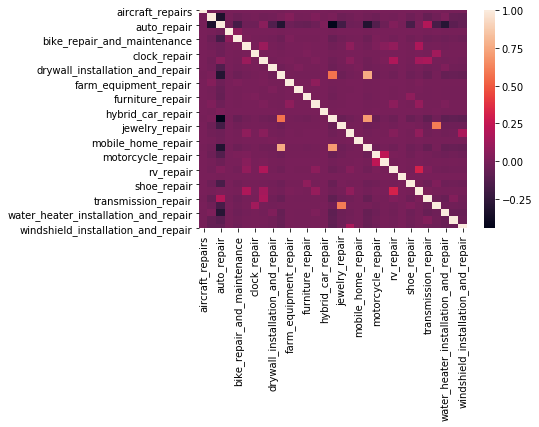

In [6]:
# check category influence
sns.heatmap(df[category_cols].corr())

In [7]:
# spot check category influence
#df[df.mobile_phone_repair == 1][category_cols].sum().sort_values(ascending=False)

In [8]:
# create category buckets

# default:auto
df["category_group"] = 'auto'

# home
df.loc[(df['appliances_and_repair']==1) | (df['drywall_installation_and_repair']==1) | 
       (df['foundation_repair']==1) | (df['generator_installation_and_repair']==1) | 
       (df['mobile_home_repair']==1) | (df['sauna_installation_and_repair']==1) | 
       (df['water_heater_installation_and_repair']==1), 'category_group'] = 'home'

# electronics
df.loc[(df['electronics_repair']==1) | (df['it_services_and_computer_repair']==1) | 
       (df['mobile_phone_repair']==1), 'category_group'] = 'electronics'

# personal
df.loc[(df['clock_repair']==1) | (df['furniture_repair']==1) | 
       (df['jewelry_repair']==1) | (df['shoe_repair']==1) | 
       (df['watch_repair']==1), 'category_group'] = 'personal'

print("# of reviews by category: \n", df.category_group.value_counts())

# of reviews by category: 
 auto           157980
electronics     29014
home            28456
personal        11380
Name: category_group, dtype: int64


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226830 entries, 0 to 226829
Data columns (total 45 columns):
user_id                                 226830 non-null object
business_id                             226830 non-null object
stars                                   226830 non-null int64
text                                    226830 non-null object
datetime                                226830 non-null datetime64[ns]
date                                    226830 non-null object
year                                    226830 non-null int64
month                                   226830 non-null int64
hour                                    226830 non-null int64
dow                                     226830 non-null int64
business_name                           226830 non-null object
business_stars                          226830 non-null float64
categories                              226830 non-null object
aircraft_repairs                        226830 non-null int64
appl

## Data Exploration

In [10]:
# not many reviews prior to 2013
df.groupby("year").size()

year
2004        1
2005        3
2006       13
2007      139
2008      465
2009      934
2010     2316
2011     4801
2012     7671
2013    13444
2014    22490
2015    34884
2016    43375
2017    49021
2018    47273
dtype: int64

In [11]:
# keep reviews from last 5 years only
df = df[df.year >= 2013]

In [12]:
# quick stats
print("# of businesses: ", df.business_id.nunique())
print("# of reviewers:  ", df.user_id.nunique())
print("# of reviews:    ", df.shape[0])

# of businesses:  10171
# of reviewers:   153281
# of reviews:     210487


Text(0, 0.5, '# Reviews')

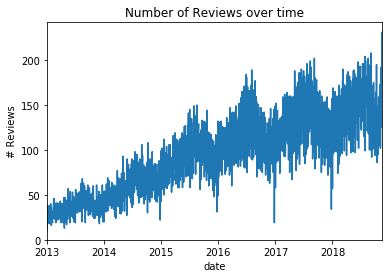

In [13]:
# reviews over time
df.groupby("date").user_id.size().plot(title="Number of Reviews over time")
sns.mpl.pyplot.ylabel("# Reviews")

Text(0, 0.5, '# of Monthly Reviews by Category')

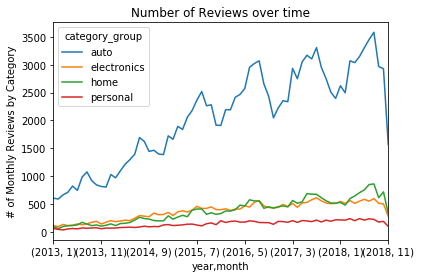

In [14]:
# reviews over time by category group
category_count = df.groupby(["category_group", "year", "month"]).user_id.size()
category_count.unstack(level=0).plot(title="Number of Reviews over time")
sns.mpl.pyplot.ylabel("# of Monthly Reviews by Category")

Text(0, 0.5, 'Star Rating')

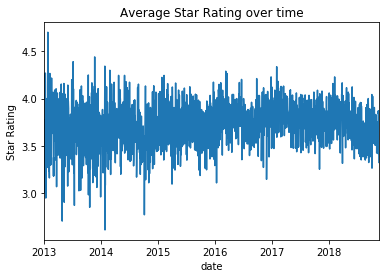

In [15]:
# ratings over time
df.groupby("date").stars.mean().plot(title="Average Star Rating over time")
sns.mpl.pyplot.ylabel("Star Rating")

Text(0, 0.5, '# of Monthly Reviews by Category')

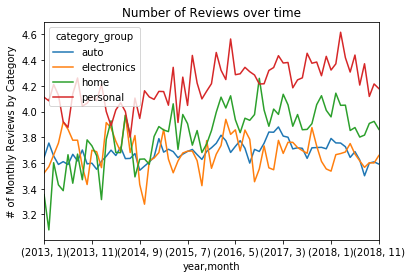

In [16]:
# ratings over time by category group
category_ratings = df.groupby(["category_group", "year", "month"]).stars.mean()
category_ratings.unstack(level=0).plot(title="Number of Reviews over time")
sns.mpl.pyplot.ylabel("# of Monthly Reviews by Category")

In [17]:
# list out star rating options
star_ratings = df.stars.drop_duplicates().sort_values().values
print("Star Ratings: ", star_ratings)

Star Ratings:  [1 2 3 4 5]


Text(0.5, 1.0, 'Rating Distribution')

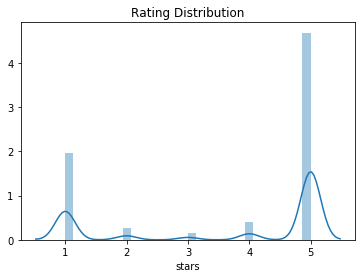

In [18]:
# distribution of ratings
sns.distplot(df.stars)
sns.mpl.pyplot.title("Rating Distribution")

Text(0.5, 0, 'Reviews per business')

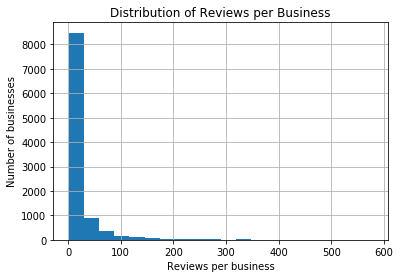

In [19]:
# see the distribution of the number of reviews per business
num_reviews = df.groupby("business_id").size()
num_reviews.hist(bins=20)
sns.mpl.pyplot.title("Distribution of Reviews per Business")
sns.mpl.pyplot.ylabel("Number of businesses")
sns.mpl.pyplot.xlabel("Reviews per business")

Text(0.5, 0, 'Reviews per business')

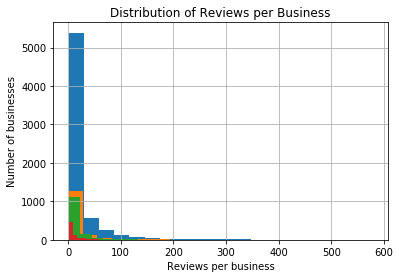

In [20]:
# see the distribution of the number of reviews per business by category (stacked)
num_cat_reviews = df.groupby(["category_group", "business_id"]).size()
num_cat_reviews.groupby("category_group").hist(bins=20)
sns.mpl.pyplot.title("Distribution of Reviews per Business")
sns.mpl.pyplot.ylabel("Number of businesses")
sns.mpl.pyplot.xlabel("Reviews per business")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21ad1550>,
      dtype=object)

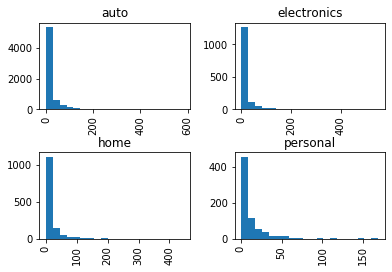

In [21]:
# see the distribution of the number of reviews per business by category (unstacked)
num_cat_reviews.hist(by="category_group", bins=20)

## Modeling
**Hypotheis**: Positive reviews (sentiment) result in higher rating (stars).

In [33]:
# cv = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words='english')
# X = cv.fit_transform(df.text).toarray()

# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_train_tfidf.shape

In [22]:
# get term frequency, inverse document frequency
tfidf = TfidfVectorizer(sublinear_tf=True, max_features=1500, min_df=5, stop_words='english')

X = tfidf.fit_transform(df.text).toarray()
y = df.stars
print("Feature shape: ", X.shape)

Feature shape:  (210487, 1500)


In [23]:
# create 20% test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
# run logistical regression
logreg = LogisticRegression(C=1e9, solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

y_train_log_pred = logreg.predict(X_train)
print("Log Reg Train Accuracy Score:", accuracy_score(y_train, y_train_log_pred))

y_test_log_pred = logreg.predict(X_test)
print("Log Reg Test Accuracy Score:", accuracy_score(y_test, y_test_log_pred))

Log Reg Train Accuracy Score: 0.8653296830553064
Log Reg Test Accuracy Score: 0.8580217587533849


In [27]:
# run random forest classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
rf.fit(X_train, y_train)

y_train_rf_pred = rf.predict(X_train)
print("RF Test Accuracy Score: ", accuracy_score(y_train, y_train_rf_pred))

y_test_rf_pred = rf.predict(X_test)
print("RF Test Accuracy Score: ", accuracy_score(y_test, y_test_rf_pred))

RF Test Accuracy Score:  0.6415442813960532
RF Test Accuracy Score:  0.6440210936386527


In [24]:
# run multinomial naive bayes
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

y_train_mnb_pred = mnb.predict(X_train)
print("Multinomial NB Train Accuracy Score: ", accuracy_score(y_train, y_train_mnb_pred))

y_test_mnb_pred = mnb.predict(X_test)
print("Multinomial NB Test Accuracy Score: ", accuracy_score(y_test, y_test_mnb_pred))

Multinomial NB Train Accuracy Score:  0.8376853594949789
Multinomial NB Test Accuracy Score:  0.8365005463442444


In [25]:
# run linear SVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

y_train_lsvc_pred = lsvc.predict(X_train)
print("Linear SVC Train Accuracy Score: ", accuracy_score(y_train, y_train_lsvc_pred))

y_test_lsvc_pred = lsvc.predict(X_test)
print("Linear SVC Test Accuracy Score: ", accuracy_score(y_test, y_test_lsvc_pred))

Linear SVC Train Accuracy Score:  0.8599789772491078
Linear SVC Test Accuracy Score:  0.8576416931920756


In [27]:
# compute cross-validation score accuracy across 10 folds (logistical regression)
logreg_cross_val_scores = cross_val_score(logreg, X, y, cv=10)

print("")
print("10-fold accuracies:\n", logreg_cross_val_scores)
print("Mean cv-accuracy:", np.mean(logreg_cross_val_scores))
print("Std of cv-accuracy:", np.std(logreg_cross_val_scores))

10-fold accuracies:
 [0.85733289 0.85700033 0.85985082 0.86008837 0.85871063 0.85761794
 0.85814053 0.85528316 0.86008172 0.85457051]
Mean cv-accuracy: 0.8578676893694988
Std of cv-accuracy: 0.0018221698477880286


In [28]:
# compute cross-validation score accuracy across 10 folds (linear SVC)
lsvc_cross_val_scores = cross_val_score(lsvc, X, y, cv=10)

print("10-fold accuracies:\n", lsvc_cross_val_scores)
print("Mean cv-accuracy:", np.mean(lsvc_cross_val_scores))
print("Std of cv-accuracy:", np.std(lsvc_cross_val_scores))

10-fold accuracies:
 [0.85543256 0.85766545 0.85961328 0.85989833 0.85747541 0.85752292
 0.85804551 0.85404789 0.85846636 0.85305017]
Mean cv-accuracy: 0.8571217899397794
Std of cv-accuracy: 0.002145689095996573


Logistical Regression Confusion Matrix


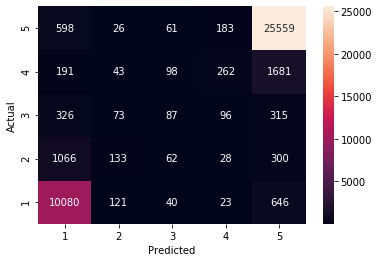

In [36]:
# confusion matrix (logistical regression)
print("Logistical Regression Confusion Matrix")
conf_mat = confusion_matrix(y_test, y_test_log_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=star_ratings, yticklabels=star_ratings)
ax.set_ylim([0,5])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Linear SVC Confusion Matrix


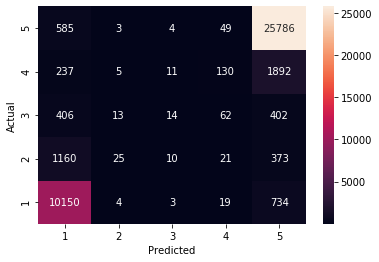

In [35]:
# confusion matrix (linear SVC)
print("Linear SVC Confusion Matrix")
conf_mat = confusion_matrix(y_test, y_test_lsvc_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=star_ratings, yticklabels=star_ratings)
ax.set_ylim([0,5])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [29]:
# logistical regression
print(classification_report(y_test, y_test_log_pred))

              precision    recall  f1-score   support

           1       0.82      0.92      0.87     10910
           2       0.34      0.08      0.13      1589
           3       0.25      0.10      0.14       897
           4       0.44      0.12      0.18      2275
           5       0.90      0.97      0.93     26427

    accuracy                           0.86     42098
   macro avg       0.55      0.44      0.45     42098
weighted avg       0.82      0.86      0.83     42098



In [38]:
# logistical regression
print(classification_report(y_test, y_test_lsvc_pred))

              precision    recall  f1-score   support

           1       0.81      0.93      0.87     10910
           2       0.50      0.02      0.03      1589
           3       0.33      0.02      0.03       897
           4       0.46      0.06      0.10      2275
           5       0.88      0.98      0.93     26427

    accuracy                           0.86     42098
   macro avg       0.60      0.40      0.39     42098
weighted avg       0.82      0.86      0.81     42098



In [ ]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
                        ('tfidf', TfidfVectorizer()),
                        ('clf', MultinomialNB()),
                    ])

In [ ]:
#Feature Importances on the occupancy dataset
for importance in zip(X_occ_train.columns.tolist(),rf_occ.feature_importances_):
    print(importance)